# Log2/Z-score Notebook

By: Megan Grout (groutm@ohsu.edu)

Adapted from code written by Dr. Marilyne Labrie and Nick Kendsersky


Last updated: 20191213

In [1]:
import os
import random
import re
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import subprocess


from scipy import signal
from scipy.stats.stats import pearsonr

import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
init_notebook_mode(connected = True)

%matplotlib notebook

In [7]:
from cycif_modules import *

## Functions

In [8]:
# This may change for each experiment, so I have not sequestered
# this code in the my_modules.py file

# This function takes in a dataframe, changes the names
# of the column in various ways, and returns the dataframe.
# For best accuracy and generalizability, the code uses
# regular expressions (regex) to find strings for replacement.
def apply_header_changes(df):
    # remove lowercase x at beginning of name
    df.columns = df.columns.str.replace("^x","")
    # remove space at beginning of name
    df.columns = df.columns.str.replace("^ ","")
    # replace space with underscore
    df.columns = df.columns.str.replace(" ","_")
    # fix typos
    df.columns = df.columns.str.replace("CKD1","CDK1")
    df.columns = df.columns.str.replace("GAG3","GATA3")
    return df

## Begin Workflow

### Get directories

In [9]:
#set directory
## needs to be user iput

# Base directory for project
base_dir = '/Users/groutm/Desktop/weewin'
base_dir = '/Users/groutm/Desktop/reproducibility'
base_dir = 'Z:\Marilyne\Axioscan\Gao_Zhang\Segmentation'
base_dir = '/Users/groutm/Desktop/gz_new'


project_name = 'ww'
project_name = 'repro'
project_name = 'gz_new'

step_suffix = 'zscore'
previous_step_suffix_long = "_bs"

# Initial input data directory
#input_data_dir = r'/Users/groutm/Desktop/TMAdata'
#input_data_dir = r'/Users/groutm/Desktop/ww_data'
input_data_dir = os.path.join(base_dir, project_name + previous_step_suffix_long)


# log2/z-score directory
#output_data_dir = r'/Users/groutm/Desktop/TMAoutputdata'
#output_data_dir = r'/Users/groutm/Desktop/ww_outputdata'
output_data_dir = os.path.join(base_dir, project_name + "_" + step_suffix)

# log2/z-score images subdirectory
#output_images_dir = r'/Users/groutm/Desktop/TMAimages'
#output_images_dir = r'/Users/groutm/Desktop/wwimages'
output_images_dir = os.path.join(output_data_dir,"images")

# Metadata directories
metadata_dir = os.path.join(base_dir, project_name + "_metadata")
metadata_images_dir = os.path.join(metadata_dir,"images")

for d in [base_dir, input_data_dir, output_data_dir, output_images_dir, 
          metadata_dir, metadata_images_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

os.chdir(input_data_dir)



In [10]:
## Comment for final workflow

ls_samples = ['TMA','ww1', 'ww10', 'ww11', 'ww12', 'ww13', 'ww15', 
              'ww16', 'ww17', 'ww19', 'ww2', 'ww20', 'ww21', 
              'ww22', 'ww23', 'ww3', 'ww4', 'ww5', 'ww6', 'ww7', 
              'ww8', 'ww9']#,'bad_header_file']

ls_samples = ['TMA1.1', 'TMA1.2', 'TMA1.3', 'TMA2.1', 'TMA2.2', 'TMA2.3']
ls_samples = ['GZ10.1', 'GZ10.2', 'GZ10.3', 'TMA',
 'GZ7.1', 'GZ6', 'GZ7.2']

ls_samples = ['A_GZ2', 'B_GZ1', 'C_GZ5', 'D_GZ4', 'E_GZ3','F_GZ6','G_GZ7', 'H_GZ9','I_GZ10','TMA']

## Import all metadata we need from the QC/EDA chapter

### metadata

In [11]:
filename = "marker_intensity_metadata.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [12]:
# Open, read in information
metadata = pd.read_csv(filename)

# Verify size
#verify_line_no(filename, metadata.shape[0] + 1)


# Verify headers
exp_cols = ['Round','Target','Channel','target_lower','full_column','marker','location']
compare_headers(exp_cols, metadata.columns.values, "Marker metadata file")

['Exp']


In [13]:
# Show some of dataframe - FYI
metadata.head()

,Round,Target,Exp,Channel,target_lower,full_column,marker,location
0,R0,AF488,300,c2,af488,AF488_Cell_Intensity_Average,AF488,cell
1,R0,AF555,1500,c3,af555,AF555_Cell_Intensity_Average,AF555,cell
2,R0,AF647,1500,c4,af647,AF647_Cell_Intensity_Average,AF647,cell
3,R0,AF750,1500,c5,af750,AF750_Cell_Intensity_Average,AF750,cell
4,R1,H3K27me3,200,c2,h3k27me3,H3K27me3_Cell_Intensity_Average,H3K27me3,cell


### not_intensities

In [14]:
filename = "not_intensities.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [15]:
# Open, read in information
not_intensities = []
with open(filename, 'r') as fh:
    not_intensities = fh.read().strip().split("\n")
    # take str, strip whitespace, split on new line character

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, len(not_intensities))

# Print to console
print("not_intensities = ")
print(not_intensities)

Verifying data read from file is the correct length...

not_intensities = 
['Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv', 'Nucleus_Roundness', 'Nucleus_Size', 'Cell_Size', 'ROI_index', 'Sample_ID', 'replicate_ID', 'Cell_ID', 'cell_type', 'cluster', 'ID']


### full_to_short_column names

In [16]:
filename = "full_to_short_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [17]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
full_to_short_names = df.set_index('full_name').T.to_dict('records')[0]

# Print information
print('full_to_short_names =')
print(full_to_short_names)

Verifying data read from file is the correct length...

full_to_short_names =
{'53BP1_Cell_Intensity_Average': '53BP1', 'AF488_Cell_Intensity_Average': 'AF488', 'AF555_Cell_Intensity_Average': 'AF555', 'AF647_Cell_Intensity_Average': 'AF647', 'AF750_Cell_Intensity_Average': 'AF750', 'AXL_Cell_Intensity_Average': 'AXL', 'CCNA2_Cell_Intensity_Average': 'CCNA2', 'CCND1_Cell_Intensity_Average': 'CCND1', 'CD45_Cell_Intensity_Average': 'CD45', 'CD4_Cell_Intensity_Average': 'CD4', 'CD68_Cell_Intensity_Average': 'CD68', 'CD8_Cell_Intensity_Average': 'CD8', 'EGFR_Cell_Intensity_Average': 'EGFR', 'Ecad_Cell_Intensity_Average': 'Ecad', 'FOXP3_Cell_Intensity_Average': 'FOXP3', 'H3K27me3_Cell_Intensity_Average': 'H3K27me3', 'KI67_Cell_Intensity_Average': 'KI67', 'MITF_Cell_Intensity_Average': 'MITF', 'PCNA_Cell_Intensity_Average': 'PCNA', 'PDGFR_Cell_Intensity_Average': 'PDGFR', 'S100_Cell_Intensity_Average': 'S100', 'Vimentin_Cell_Intensity_Average': 'Vimentin', 'p4EBP1_Cell_Intensity_Average': 'p

### short_to_full_column_names

In [18]:
filename = "short_to_full_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [19]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
short_to_full_names = df.set_index('short_name').T.to_dict('records')[0]

# Print information
print('short_to_full_names =')
print(short_to_full_names)

Verifying data read from file is the correct length...

short_to_full_names =
{'53BP1': '53BP1_Cell_Intensity_Average', 'AF488': 'AF488_Cell_Intensity_Average', 'AF555': 'AF555_Cell_Intensity_Average', 'AF647': 'AF647_Cell_Intensity_Average', 'AF750': 'AF750_Cell_Intensity_Average', 'AXL': 'AXL_Cell_Intensity_Average', 'CCNA2': 'CCNA2_Cell_Intensity_Average', 'CCND1': 'CCND1_Cell_Intensity_Average', 'CD45': 'CD45_Cell_Intensity_Average', 'CD4': 'CD4_Cell_Intensity_Average', 'CD68': 'CD68_Cell_Intensity_Average', 'CD8': 'CD8_Cell_Intensity_Average', 'EGFR': 'EGFR_Cell_Intensity_Average', 'Ecad': 'Ecad_Cell_Intensity_Average', 'FOXP3': 'FOXP3_Cell_Intensity_Average', 'H3K27me3': 'H3K27me3_Cell_Intensity_Average', 'KI67': 'KI67_Cell_Intensity_Average', 'MITF': 'MITF_Cell_Intensity_Average', 'PCNA': 'PCNA_Cell_Intensity_Average', 'PDGFR': 'PDGFR_Cell_Intensity_Average', 'S100': 'S100_Cell_Intensity_Average', 'Vimentin': 'Vimentin_Cell_Intensity_Average', 'p4EBP1': 'p4EBP1_Cell_Intensity_Av

### color information

#### Samples

In [20]:
filename = "sample_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [21]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
sample_color_dict = df.set_index('Sample_ID').T.to_dict('rgb')[0]

# Print information
print('sample_color_dict =')
print(sample_color_dict)


Verifying data read from file is the correct length...

sample_color_dict =
{'A_GZ2': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'B_GZ1': (0.8616090647292522, 0.536495730113334, 0.19548899031476086), 'C_GZ5': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), 'D_GZ4': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), 'E_GZ3': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), 'F_GZ6': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'G_GZ7': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), 'H_GZ9': (0.433280341176423, 0.6065273407962815, 0.9585467098271748), 'I_GZ10': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), 'TMA': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)}


#### Channels

In [22]:
filename = "channel_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [23]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
channel_color_dict = df.set_index('Channel').T.to_dict('rgb')[0]

# Print information
print('channel_color_dict =')
print(channel_color_dict)


Verifying data read from file is the correct length...

channel_color_dict =
{'c3': (1.0, 0.6470588235294118, 0.0), 'c4': (1.0, 0.0, 0.0), 'c5': (0.25098039215686274, 0.8784313725490196, 0.8156862745098039), 'c2': (0.0, 0.5019607843137255, 0.0)}


#### Round

In [24]:
filename = "round_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [25]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
round_color_dict = df.set_index('Round').T.to_dict('rgb')[0]

# Print information
print('round_color_dict =')
print(round_color_dict)

Verifying data read from file is the correct length...

round_color_dict =
{'R0': (0.28685356234627135, 0.13009829239513535, 0.23110332132624437), 'R1': (0.3736023974468758, 0.214424058315835, 0.3978381676792029), 'R2': (0.4159341362257507, 0.3236230119238674, 0.5522993139842536), 'R3': (0.4347275623260717, 0.45841778084048856, 0.6693193307565182), 'R4': (0.45985383722977585, 0.5938507827180669, 0.7299938636762819), 'R5': (0.5193510814616777, 0.7186903518953451, 0.7537488291211205), 'R6': (0.6251959781814483, 0.8211474484187268, 0.77115296242133), 'R7': (0.7684256891219349, 0.8992667116749021, 0.8171383269422353)}


#### Cell Type

In [26]:
filename = "celltype_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [27]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
celltype_color_dict = df.set_index('cell_type').T.to_dict('rgb')[0]

# Print information
print('celltype_color_dict =')
print(celltype_color_dict)

Verifying data read from file is the correct length...

celltype_color_dict =
{'STROMA': (0.86, 0.3712, 0.33999999999999997), 'CANCER': (0.33999999999999997, 0.86, 0.3712), 'IMMUNE': (0.3712, 0.33999999999999997, 0.86)}


## Import data

In [30]:
# Import all data files for this portion of workflow

# First gather information on expected headers using first file in ls_samples

# Read in the first row of the file correpsonding to the first sample (index = 0)
# in ls_samples
df = pd.read_csv(ls_samples[0] + 
                 previous_step_suffix_long + ".csv", nrows = 1, index_col = 0)

# Apply the changes to the headers as specified in above funciton
df = apply_header_changes(df)

# Set variable to hold default header values
expected_headers = df.columns.values

print("df index name is currently",df.index.name)

df index name is currently None


In [31]:
df.head()

,53BP1_Cell_Intensity_Average,AXL_Cell_Intensity_Average,CCNA2_Cell_Intensity_Average,CCND1_Cell_Intensity_Average,CD45_Cell_Intensity_Average,CD4_Cell_Intensity_Average,CD68_Cell_Intensity_Average,CD8_Cell_Intensity_Average,Cell_Size,EGFR_Cell_Intensity_Average,...,p75_Cell_Intensity_Average,pATM_Cell_Intensity_Average,pATR_Cell_Intensity_Average,pCHK2_Cell_Intensity_Average,pEGFR_Cell_Intensity_Average,pGSK3b_Cell_Intensity_Average,pH2AX_Cell_Intensity_Average,pHH3_Cell_Intensity_Average,pS6_Cell_Intensity_Average,cell_type
A_GZ2_Cell_0,2.330708,0.280298,0.0,0.142364,0.408685,0.671926,0.0,1.098602,329,0.139297,...,1.099649,0.591459,1.598614,1.828221,1.037077,1.502783,0.028199,1.463818,1.039417,CANCER


In [32]:
print("Used " + ls_samples[0] + previous_step_suffix_long +
      ".csv to determine the expected, corrected headers for all files.")
print("There headers are: \n" + ", ".join([h for h in expected_headers]) + ".")

Used A_GZ2_bs.csv to determine the expected, corrected headers for all files.
There headers are: 
53BP1_Cell_Intensity_Average, AXL_Cell_Intensity_Average, CCNA2_Cell_Intensity_Average, CCND1_Cell_Intensity_Average, CD45_Cell_Intensity_Average, CD4_Cell_Intensity_Average, CD68_Cell_Intensity_Average, CD8_Cell_Intensity_Average, Cell_Size, EGFR_Cell_Intensity_Average, Ecad_Cell_Intensity_Average, FOXP3_Cell_Intensity_Average, H3K27me3_Cell_Intensity_Average, KI67_Cell_Intensity_Average, MITF_Cell_Intensity_Average, Nuc_X, Nuc_X_Inv, Nuc_Y, Nuc_Y_Inv, Nucleus_Roundness, Nucleus_Size, PCNA_Cell_Intensity_Average, PDGFR_Cell_Intensity_Average, ROI_index, S100_Cell_Intensity_Average, Sample_ID, Vimentin_Cell_Intensity_Average, p4EBP1_Cell_Intensity_Average, p75_Cell_Intensity_Average, pATM_Cell_Intensity_Average, pATR_Cell_Intensity_Average, pCHK2_Cell_Intensity_Average, pEGFR_Cell_Intensity_Average, pGSK3b_Cell_Intensity_Average, pH2AX_Cell_Intensity_Average, pHH3_Cell_Intensity_Average, p

In [33]:
# Import all dfs

## TO-DO: include check that imported df is the expected size and shape...

dfs = {}
for sample in ls_samples:
    # Open file
    ################################
    # only reading first 500 lines #
    ################################
    if not os.path.exists(sample+previous_step_suffix_long+".csv"):
        print("File " + sample+previous_step_suffix_long+".csv" +
             " does not exist. Removing from analysis...")
        ls_samples.remove(sample)
        continue
    
    df = pd.read_csv(sample + previous_step_suffix_long + ".csv", 
                     index_col = 0) #,  nrows = 500)
    
    # Check for empty df
    # if so, don't continue trying to process df
    if df.shape[0] == 0:
        print('Zero content lines detected in ' + sample + ' file.'
              'Removing from analysis...')
        ls_samples.remove(sample)
        continue
    
    # Instead of reading only the top 500 row in the file,
    # let's read in all rows and then only use a random
    # sampling (w/o replacement) of 500
    
    
    # Verify that the loaded df are the right length
    try:
        verify_line_no(sample + previous_step_suffix_long + ".csv", 
                   df.shape[0] + 1)
    except:
        pass
    # adding 1 because we expect the header was detected 
    # during file import and not counted towards length of df
    
     # Manipulations necessary for concatenation
    df = apply_header_changes(df)
    df = df[[x for x in sorted(df.columns.values)]]
    
    # Compare headers of new df against what is expected
    compare_headers(expected_headers, df.columns.values, sample)
    df['Sample_ID'] = sample

    # For cases where we have samples called TMA1.1, TMA1.2, TMA1.3, etc.
    # Using regular expressions (regex) to extract the characters in the
    # sample name from TMA to the following digits, stopping at the period
    #if 'ROI_index' in df.columns.values:
    #    df['ROI_slide'] = re.findall(r'(TMA\d+)',sample)[0]    
    
    # Add to df of dfs 
    dfs[sample] = df
    



#Merge dfs into one df
df = pd.concat(dfs.values(), ignore_index=False , sort = False)
del dfs


Zero content lines detected in H_GZ9 file.Removing from analysis...


Let's take a look at a few features to make sure our dataframe is as expected

In [34]:
df.shape

(692976, 38)

In [35]:
df.index 

Index(['A_GZ2_Cell_0', 'A_GZ2_Cell_2', 'A_GZ2_Cell_6', 'A_GZ2_Cell_7',
       'A_GZ2_Cell_8', 'A_GZ2_Cell_9', 'A_GZ2_Cell_10', 'A_GZ2_Cell_11',
       'A_GZ2_Cell_12', 'A_GZ2_Cell_15',
       ...
       'TMA_Cell_143421', 'TMA_Cell_143422', 'TMA_Cell_143423',
       'TMA_Cell_143425', 'TMA_Cell_143426', 'TMA_Cell_143427',
       'TMA_Cell_143428', 'TMA_Cell_143429', 'TMA_Cell_143430',
       'TMA_Cell_143433'],
      dtype='object', length=692976)

In [36]:
#check for NaN entries (should not be any unless columns do not align)
# if there are any null values, then print names of columns containing
# null values
if df.isnull().any().any():
    print(df.columns[df.isnull().any()])

#in 'if' statement, false means no NaN entries True means NaN entries 

In [37]:
# Check that all expected files were imported into final dataframe

if sorted(df.Sample_ID.unique()) == sorted(ls_samples):
    print("All expected filenames present in big df Sample_ID column.")
else:
    compare_headers(['no samples'], df.Sample_ID.unique(), "big df Sample_ID column")

['no samples']
['A_GZ2' 'B_GZ1' 'C_GZ5' 'D_GZ4' 'E_GZ3' 'F_GZ6' 'G_GZ7' 'TMA']


## Log2 transformation

In [38]:
## no need to transpose df, non-intensity columns present 
# in df but are not transformed by log2 nor by z-scoring

# add 1 
df.loc[:, ~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].copy() + 1

In [39]:
# apply log2
df.loc[:,~df.columns.isin(not_intensities)] = \
    np.log2(df.loc[:, ~df.columns.isin(not_intensities)])
print('log2 transform finished')

log2 transform finished


## Z-score transformations

In [40]:
# Z-score the rows (apply() with axis = 1, only perform on intensity data)
df.loc[:,~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].apply(
        lambda row: (row - row.median())/(row.std(ddof=0)), axis = 1)
df.dropna(how = 'all', inplace = True, axis = 1)
print('zscore rows finished')

# Z-score the columns (apply() with axis = 0, only perform on intensity data)
df.loc[:,~df.columns.isin(not_intensities)] = \
    df.loc[:,~df.columns.isin(not_intensities)].apply(
        lambda row: (row - row.median())/(row.std(ddof=0)), axis = 0)
df.dropna(how = 'all', inplace = True, axis = 1)
print('zscore columns finished')

zscore rows finished
zscore columns finished


## Visualizations

### Heatmap

We will only be plotting ~10k cells in the interest of time/computing resources. We want these 10k lines in our original df to be sampled randomly, without replacement, with the caveat that the proportions of all samples in the data remains the same in this subset. If the size of the dataframe is > 10k rows, then we will proceed with the entire dataset.

In [41]:
heatmap_row_count = min(10000, df.shape[0])

In [42]:
# Create df of each feature type, its proportion in the full df,
# and the number of rows we want for a sum of heatmap_row_count rows
counts_for_heatmap = create_equal_value_counts(df, 'Sample_ID',heatmap_row_count)
counts_for_heatmap

,current_row_count,prop,desired_row_count
A_GZ2,66137,0.095439,1250.0
B_GZ1,1443,0.002082,1250.0
C_GZ5,185,0.000267,185.0
D_GZ4,47135,0.068018,1250.0
E_GZ3,5502,0.007940,1250.0
F_GZ6,54962,0.079313,1250.0
G_GZ7,425692,0.614295,1250.0
TMA,91920,0.132645,1250.0


In [45]:
# Create new df to hold our heatmap data
heatmap_data = pd.DataFrame(columns = df.columns)

# populate the df
for sample in df.Sample_ID.unique():
    a = counts_for_heatmap.loc[counts_for_heatmap.index == sample,'current_row_count'].values[0]
    size = int(counts_for_heatmap.loc[counts_for_heatmap.index == sample,'desired_row_count'].values[0])
    random_rows = np.random.choice(a = a, size = size, replace = False)
    df_sample = df.loc[df['Sample_ID'] == sample,:]
    heatmap_data = heatmap_data.append(df_sample.iloc[random_rows,:])
    #random_rows = np.random.choice(heatmap_samples.loc[sample,values])
    #heatmap_data = heatmap_data.append()

In [46]:
## We want to make sure our sampling worked as expected.

# In our new dataframe, how many rows do we actually have for each sample?
# What is the proportion of each sample's rows of the total dataframe?

# Compare this with the 'counts_for_heatmap' above
# Note there might be slight differences in 'prop' due to rounding

create_equal_value_counts(heatmap_data, 'Sample_ID', heatmap_data.shape[0])

,current_row_count,prop,desired_row_count
A_GZ2,1250,0.139899,1117.0
B_GZ1,1250,0.139899,1117.0
C_GZ5,185,0.020705,185.0
D_GZ4,1250,0.139899,1117.0
E_GZ3,1250,0.139899,1117.0
F_GZ6,1250,0.139899,1117.0
G_GZ7,1250,0.139899,1117.0
TMA,1250,0.139899,1117.0


Get data structures to map colors to columns and rows...

In [47]:
sample_row_colors = heatmap_data.Sample_ID.map(sample_color_dict)

sample_row_colors[1:5]

A_GZ2_Cell_64899    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_82941    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_39378    (0.9677975592919913, 0.44127456009157356, 0.53...
A_GZ2_Cell_38920    (0.9677975592919913, 0.44127456009157356, 0.53...
Name: Sample_ID, dtype: object

In [48]:
row_celltype_colors = heatmap_data.cell_type.map(celltype_color_dict)

row_celltype_colors[1:5]

A_GZ2_Cell_64899    (0.3712, 0.33999999999999997, 0.86)
A_GZ2_Cell_82941    (0.86, 0.3712, 0.33999999999999997)
A_GZ2_Cell_39378    (0.86, 0.3712, 0.33999999999999997)
A_GZ2_Cell_38920    (0.86, 0.3712, 0.33999999999999997)
Name: cell_type, dtype: object

In [49]:
column_channel_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Channel']]['Channel'].map(channel_color_dict)


column_channel_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_channel_colors.head()

53BP1_Cell_Intensity_Average    (0.25098039215686274, 0.8784313725490196, 0.81...
AXL_Cell_Intensity_Average                         (1.0, 0.6470588235294118, 0.0)
CCNA2_Cell_Intensity_Average                       (1.0, 0.6470588235294118, 0.0)
CCND1_Cell_Intensity_Average                                      (1.0, 0.0, 0.0)
CD45_Cell_Intensity_Average     (0.25098039215686274, 0.8784313725490196, 0.81...
Name: Channel, dtype: object

In [50]:
column_round_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Round']]['Round'].map(round_color_dict)


column_round_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_round_colors.head()

53BP1_Cell_Intensity_Average    (0.3736023974468758, 0.214424058315835, 0.3978...
AXL_Cell_Intensity_Average      (0.4347275623260717, 0.45841778084048856, 0.66...
CCNA2_Cell_Intensity_Average    (0.3736023974468758, 0.214424058315835, 0.3978...
CCND1_Cell_Intensity_Average    (0.4347275623260717, 0.45841778084048856, 0.66...
CD45_Cell_Intensity_Average     (0.6251959781814483, 0.8211474484187268, 0.771...
Name: Round, dtype: object

In [53]:
# Create data structure to hold everything we need for row/column annotations
# annotations is a dictionary
## IMPORTANT - if you use 'annotations', it MUST have both 'rows' and 'cols'
## objects inside. These can be empty lists, but they must be there!
anns = {}

# create a data structure to hold everything we need for only row annotations
# row_annotations is a list, where each item therein is a dictioary corresponding
# to all of the data pertaining to that particular annotation
# Adding each item (e.g., Sample, then Cluster), one at a time to ensure ordering
# is as anticipated on figure
row_annotations = []
row_annotations.append({'label':'Sample','type':'row','mapping':sample_row_colors,'dict':sample_color_dict,
                        'location':'center left','bbox_to_anchor':(0, 0.5)})
#row_annotations.append({'label':'Cell type','type':'row','mapping':row_celltype_colors,
#                        'dict':celltype_color_dict,
#                        'location':'lower left','bbox_to_anchor':(0, 0.65)})# Add all row information into the annotations dictionary
anns['rows'] = row_annotations


# Now we repeat the process for column annotations
col_annotations = []
col_annotations.append({'label':'Round','type':'column','mapping':column_round_colors,'dict':round_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.50)})

col_annotations.append({'label':'Column','type':'column','mapping':column_channel_colors,'dict':channel_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.75)})
anns['cols'] = col_annotations

#### Actually plot the heatmap

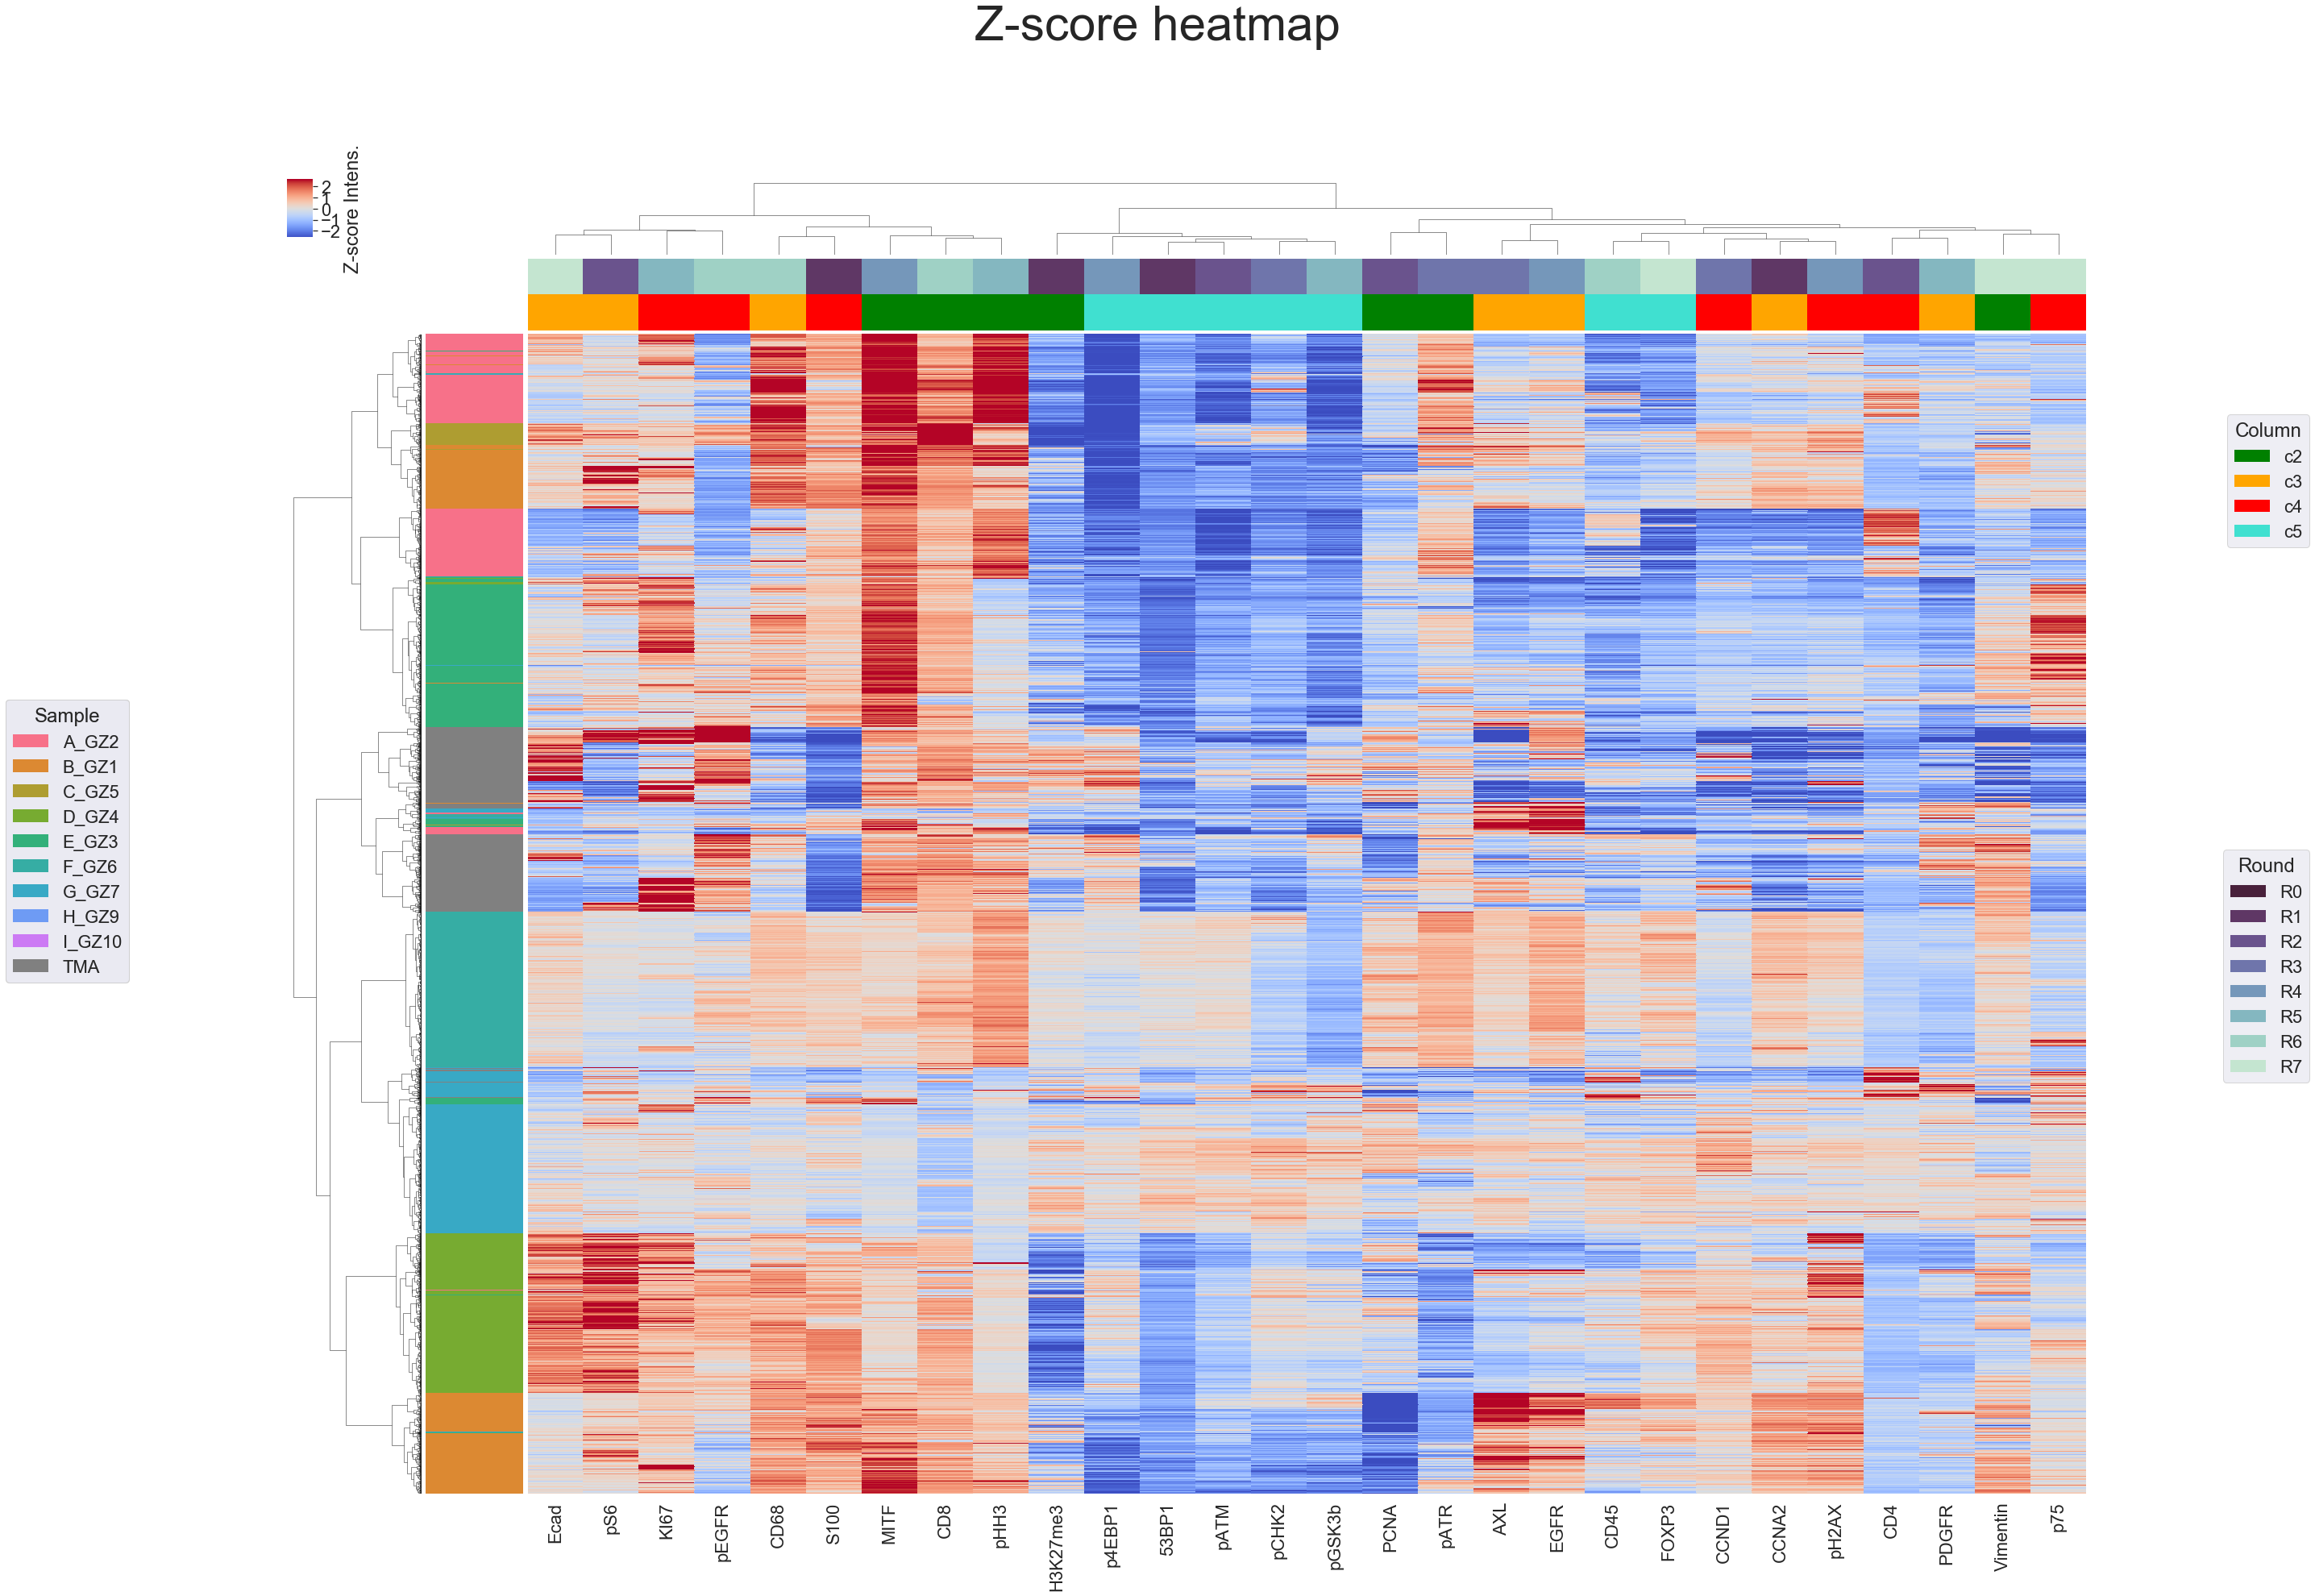

In [54]:
heatmap_function(data = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)],
    title = "Z-score heatmap",
               # define method, metric, and color map
          method = 'ward', metric = 'euclidean',cmap = 'coolwarm',
               # colorbar (legend coloring of main plot) 
               cbar_kws = {'label':'Z-score Intens.'},
               # xticklabels - want to have the nicknames instead of full names
    xticklabels = [full_to_short_names[name] for name in 
                     heatmap_data.loc[:,
                                 ~heatmap_data.columns.isin(not_intensities)].columns.values],
                 save_loc = output_images_dir,
                 row_cluster = True, col_cluster = True,
                    annotations = anns
          )

## Bar plot of log2/z-score data

In [55]:
# Create sorted list of sample IDs
samples = sorted(list(df.Sample_ID.copy().unique()))

In [56]:
# Get counts for each Sample_ID, sorted by Sample_ID
counts = pd.DataFrame(df.Sample_ID.value_counts()).sort_index()
counts = counts.rename(columns = {'Sample_ID':'counts'})
counts['Sample_ID'] = counts.index
counts['color'] = counts.apply(lambda row: sample_color_dict[row['Sample_ID']], axis = 1)
counts.head()

,counts,Sample_ID,color
A_GZ2,66137,A_GZ2,"(0.9677975592919913, 0.44127456009157356, 0.53..."
B_GZ1,1443,B_GZ1,"(0.8616090647292522, 0.536495730113334, 0.1954..."
C_GZ5,185,C_GZ5,"(0.6804189127793346, 0.6151497514677574, 0.194..."
D_GZ4,47135,D_GZ4,"(0.46810256823426105, 0.6699492535792404, 0.19..."
E_GZ3,5502,E_GZ3,"(0.20125317221201128, 0.6907920815379025, 0.47..."


In [57]:
fig = go.Figure()
title = 'Cell counts by Sample_ID - log2 and z-score'

for sample in ls_samples:
    fig.add_trace(go.Bar(
        x=counts.loc[counts['Sample_ID']==sample,'Sample_ID'], 
        y = counts.loc[counts['Sample_ID']==sample,'counts'],
        text = counts.loc[counts['Sample_ID']==sample,'counts'], textposition='outside',
        marker=dict(
            color='rgb' + str(sample_color_dict[sample])
        ), showlegend = False
    ))
fig.update_layout(title = title, plot_bgcolor = 'white')
fig.update_xaxes(title_text = 'Sample ID', linecolor = 'black')
fig.update_yaxes(title_text = 'Cell count', linecolor = 'black')
#plot(fig)
fig.write_image(output_images_dir + "/" + title.replace(" ","_") + ".png")


### Distributions of log2/z-score data

### Correlation plot

Get Pearson correlations and P values for all marker values

First, get we need to determine how many columns we will be evaulating. And prepare empty Numpy arrays to hold our data.

In [60]:
n_corr_cols = len(df.columns[~df.columns.isin(not_intensities)])
print(n_corr_cols)

28


In [61]:
pvalues = np.empty((n_corr_cols, n_corr_cols))
corrvalues = np.empty((n_corr_cols,n_corr_cols))

Next, we create a dataframe of only the columns we will use for this analysis.

In [62]:
for_corr = df.loc[:,~df.columns.isin(not_intensities)].copy()
for_corr = for_corr.rename(columns = full_to_short_names)
for_corr.shape

(692976, 28)

Then, we iterate through each pair of columns, calculate the Pearson correlation and associated p-value, and then store the values.

In [63]:
for i in range(for_corr.shape[1]):
    for j in range(0,for_corr.shape[1]):
        col1 = for_corr[for_corr.columns.values[i]]
        col2 = for_corr[for_corr.columns.values[j]]
        corrvalues[i,j] = pearsonr(col1,col2)[0]
        pvalues[i,j] = pearsonr(col1,col2)[1]

To prepare for visualization, we are rounding the values.

In [64]:
corrvalues = pd.DataFrame(corrvalues).round(3)
corrvalues.columns = for_corr.columns.values
corrvalues.index = for_corr.columns.values

pvalues = pd.DataFrame(pvalues)
pvalues.columns = for_corr.columns.values
pvalues.index = for_corr.columns.values

Option 1: no correlation value on plot, just put p value and have star is p<=0.05

In [65]:
def p_add_star(row):
    m = [str('{:0.3e}'.format(m)) + "*" 
         if m <= 0.05 \
         else str('{:0.3e}'.format(m))
        for m in row ]
    return pd.Series(m)


p_w_star = pvalues.copy()
p_w_star = p_w_star.apply(lambda row: p_add_star(row), axis = 1)
p_w_star.columns = for_corr.columns.values
p_w_star.head()


,53BP1,AXL,CCNA2,CCND1,CD45,CD4,CD68,CD8,EGFR,Ecad,...,p4EBP1,p75,pATM,pATR,pCHK2,pEGFR,pGSK3b,pH2AX,pHH3,pS6
53BP1,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,4.916e-283*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,4.856e-59*
AXL,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,3.292e-77*,0.000e+00*,0.000e+00*,0.000e+00*,4.774e-221*,...,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*
CCNA2,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*
CCND1,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,1.642e-44*,0.000e+00*,4.561e-307*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*
CD45,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,2.263e-112*,0.000e+00*,0.000e+00*,0.000e+00*,...,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*,0.000e+00*


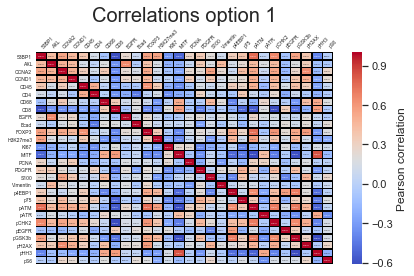

In [66]:
### Correlation visualization

sb.set()

x_axis_labels = for_corr.columns.values.tolist()
y_axis_labels = for_corr.columns.values.tolist()

ax = sb.heatmap(corrvalues, 
                 annot=p_w_star, annot_kws={"size": 1.25},fmt='s',
                 xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                 cbar_kws = {'label':'Pearson correlation'},
                linecolor = 'black', linewidth = 0.5,
                 cmap = 'coolwarm'
                )
plt.yticks(rotation=0, size = 5)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
plt.xticks(rotation=45, size = 5)
plt.setp(ax.xaxis.get_majorticklabels(), ha='left')


ax.set_title(label = "Correlations option 1", fontsize = 20)
plt.tight_layout()

filename = "correlations_option1.png"
filename = os.path.join(output_images_dir, filename)
plt.savefig(filename,dpi=500)

Option 2: include correlation and 1-3 stars depending on p-value. 1 star: p-value <= 0.05; 2 stars: p-value <= 0.01; 3 stars: p-value <= 0.001.

In [67]:
def p_to_star(row):
    output  = []
    for item in row:
        if item <= 0.001:
            stars = 3
        elif item <= 0.01:
            stars = 2
        elif item <= 0.05:
            stars = 1
        else:
            stars = 0
        value = ''
        for i in range(stars):
            value += '*'
        output.append(value)
    return pd.Series(output)


p_as_stars = pvalues.copy()
p_as_stars = p_as_stars.apply(lambda row: p_to_star(row), axis = 1)
p_as_stars.columns = for_corr.columns.values
p_as_stars.head()


,53BP1,AXL,CCNA2,CCND1,CD45,CD4,CD68,CD8,EGFR,Ecad,...,p4EBP1,p75,pATM,pATR,pCHK2,pEGFR,pGSK3b,pH2AX,pHH3,pS6
53BP1,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
AXL,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
CCNA2,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
CCND1,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
CD45,***,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***


In [68]:
corr_w_star = corrvalues.round(2).astype(str) + p_as_stars
corr_w_star.head()

,53BP1,AXL,CCNA2,CCND1,CD45,CD4,CD68,CD8,EGFR,Ecad,...,p4EBP1,p75,pATM,pATR,pCHK2,pEGFR,pGSK3b,pH2AX,pHH3,pS6
53BP1,1.0***,0.44***,0.55***,0.46***,0.38***,0.14***,-0.1***,-0.6***,0.26***,0.08***,...,0.33***,0.4***,0.76***,0.04***,0.66***,-0.1***,0.56***,0.38***,-0.39***,-0.02***
AXL,0.44***,1.0***,0.49***,0.45***,0.14***,0.02***,0.18***,-0.34***,0.66***,-0.04***,...,0.14***,0.25***,0.44***,0.17***,0.45***,-0.12***,0.18***,0.35***,-0.11***,-0.05***
CCNA2,0.55***,0.49***,1.0***,0.5***,0.34***,0.14***,0.37***,-0.35***,0.24***,0.15***,...,0.08***,0.44***,0.52***,0.08***,0.54***,-0.15***,0.27***,0.65***,-0.14***,0.28***
CCND1,0.46***,0.45***,0.5***,1.0***,0.15***,-0.08***,0.16***,-0.32***,0.28***,0.23***,...,0.19***,0.24***,0.51***,-0.02***,0.48***,-0.04***,0.39***,0.5***,-0.25***,0.24***
CD45,0.38***,0.14***,0.34***,0.15***,1.0***,0.51***,0.03***,-0.27***,-0.09***,-0.07***,...,0.34***,0.28***,0.49***,-0.15***,0.44***,0.16***,0.42***,0.33***,-0.27***,0.06***


In [69]:
corrvalues.shape

(28, 28)

In [70]:
corr_w_star.shape

(28, 28)

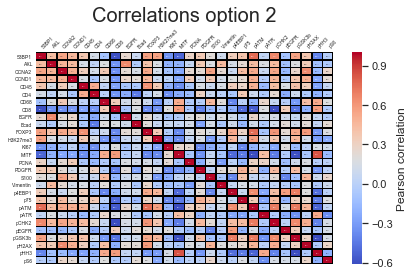

In [71]:
### Correlation visualization

sb.set()

x_axis_labels = for_corr.columns.values.tolist()
y_axis_labels = for_corr.columns.values.tolist()

ax = sb.heatmap(corrvalues, 
                 annot=corr_w_star, annot_kws={"size": 1.25},fmt='s',
                 xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                 cbar_kws = {'label':'Pearson correlation'},
                linecolor = 'black', linewidth = 0.5,
                 cmap = 'coolwarm'
                )
plt.yticks(rotation=0, size = 5)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
plt.xticks(rotation=45, size = 5)
plt.setp(ax.xaxis.get_majorticklabels(), ha='left')


ax.set_title(label = "Correlations option 2", fontsize = 20)
plt.tight_layout()

filename = "correlations_option2.png"
filename = os.path.join(output_images_dir, filename)
plt.savefig(filename,dpi=500)

Save correlations and p-value data

In [72]:
filename = "zscore_pearson_correlations.csv"
filename = os.path.join(output_data_dir, filename)
corrvalues.to_csv(filename, index = True)

In [73]:
filename = "zscore_pearson_p-values.csv"
filename = os.path.join(output_data_dir, filename)
pvalues.to_csv(filename, index = True)

### Drop any other rows or columns we want to before saving data

In [73]:
# Let's take a look
df.columns.values

array(['53BP1_Cell_Intensity_Average', 'AXL_Cell_Intensity_Average',
       'BRCA1_Cell_Intensity_Average', 'CCNA2_Cell_Intensity_Average',
       'CCNB1_Cell_Intensity_Average', 'CCND1_Cell_Intensity_Average',
       'CCNE_Cell_Intensity_Average', 'CD44_Cell_Intensity_Average',
       'CD45_Cell_Intensity_Average', 'CD4_Cell_Intensity_Average',
       'CD68_Cell_Intensity_Average', 'CD8_Cell_Intensity_Average',
       'CDK1_Cell_Intensity_Average', 'CKs_Cell_Intensity_Average',
       'Cell_Size', 'EGFR_Cell_Intensity_Average',
       'Ecad_Cell_Intensity_Average', 'GATA3_Cell_Intensity_Average',
       'H3K27_Cell_Intensity_Average', 'HER2_Cell_Intensity_Average',
       'KI67_Cell_Intensity_Average', 'MMP9_Cell_Intensity_Average',
       'Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv', 'Nucleus_Roundness',
       'Nucleus_Size', 'PCNA_Cell_Intensity_Average',
       'PDGFR_Cell_Intensity_Average', 'PTEN_Cell_Intensity_Average',
       'ROI_index', 'ROI_slide', 'Rad51_Cell_Intensity_Avera

For the sake of example, I will operate on a copy of df, called df_copy

In [74]:
# You MUST do df.copy()
# 'df_copy = df' would essentially 
# give you two different names for the
# SAME dataframe, so operating on one
# would also operate on the other
df_copy = df.copy()

#### Operate on entire rows or columns

In [75]:
# Drop columns
my_cols = []
df_copy = df_copy.drop(columns = my_cols)

In [76]:
# Keep only specific columns (explained below)
my_cols = []
my_cols = df.columns.values
df_copy = df_copy.loc[:,my_cols]

#### Operate on rows and columns using filtering criteria

In [77]:
# Keep only certain rows based off of criteria

# use df.loc[] to filter
# df.loc[rows,columns]
# df.loc[:,certain_cols] --> keep all rows ':', only certain cols
# df.loc[certain_rows,:] --> keep only certain row, all cols ':'

# Say we only want certain values for Sample_ID
print(df_copy.Sample_ID.unique())
keep = ['TMA1.1','TMA1.2','TMA1.3','TMA2.1','TMA2.2','TMA2.3']
df_copy = df_copy.loc[df_copy['Sample_ID'].isin(keep),:]
print(df_copy.Sample_ID.unique())

['TMA1.1' 'TMA1.2' 'TMA1.3' 'TMA2.1' 'TMA2.2' 'TMA2.3']
['TMA1.1' 'TMA1.2' 'TMA1.3' 'TMA2.1' 'TMA2.2' 'TMA2.3']


In [78]:
# Filter on multiple criteria
# '&' or 'and'
# '|' or 'or'
# you MUST have parentheses around each logic expression!
df_copy = df_copy.loc[
    (df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        | (df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

['TMA1.1' 'TMA1.2' 'TMA1.3' 'TMA2.1' 'TMA2.2' 'TMA2.3']


In [79]:
# Remove rows based off of certain criteria
# note the negating tilde '~'!

df_copy = df_copy.loc[
    (~df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        & (~df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

[]


### Save the data by Sample_ID

In [74]:
# Check for existence of output file first
for sample in ls_samples:
    filename = os.path.join(output_data_dir+ "/" + sample + "_" + step_suffix + ".csv")
    if os.path.exists(filename):
        print("File by name "+filename+" already exists.")

In [75]:
# Save output files
for sample in ls_samples:
    df_save = df.loc[df['Sample_ID'] == sample,:]
    filename = os.path.join(output_data_dir+ "/" + sample + "_" + step_suffix + ".csv")
    df_save.to_csv(filename, index = True)
